In [1]:

import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from PIL import Image
import requests
import numpy as np
from numpy import dot
from numpy.linalg import norm
import os
from os import path
import matplotlib.pyplot as plt


In [2]:
class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights='imagenet') # VGG 모델 
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output) #4096

    def extract(self, img):
        img = img.resize((224, 224)) # 사이즈 조정
        img = img.convert('RGB') # 공간 색상 변경
        x = image.img_to_array(img) # 객체를 받아서 넘파이 배열로 변환
        x = np.expand_dims(x, axis=0) # 이전 단계에서 생성한 이미지 배열 x 에 차원을 추가
        x = preprocess_input(x) # VGG16에 알맞게 이지 데이터 전처리
        # Extract Features
        feature = self.model.predict(x)[0] # 첫번째 예측값만 가져옴
        return feature / np.linalg.norm(feature) # 정규화

In [3]:
fe = FeatureExtractor()
df = pd.read_csv("pokemon.csv")
features = [] # 데이터 리스트
img_paths = [] # 주소 리스트


for i in df['Name']: # 모든 사진
    try:
        image_path = f"./images/images/{i}.png"
        if not path.exists(image_path):
            image_path = f"./images/images/{i}.jpg"
        img = Image.open(image_path)
        feature = fe.extract(img)
        img_paths.append(image_path)
        features.append(feature)
    except Exception as e:
        print('예외가 발생했습니다.', e)


c:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 87ms/step


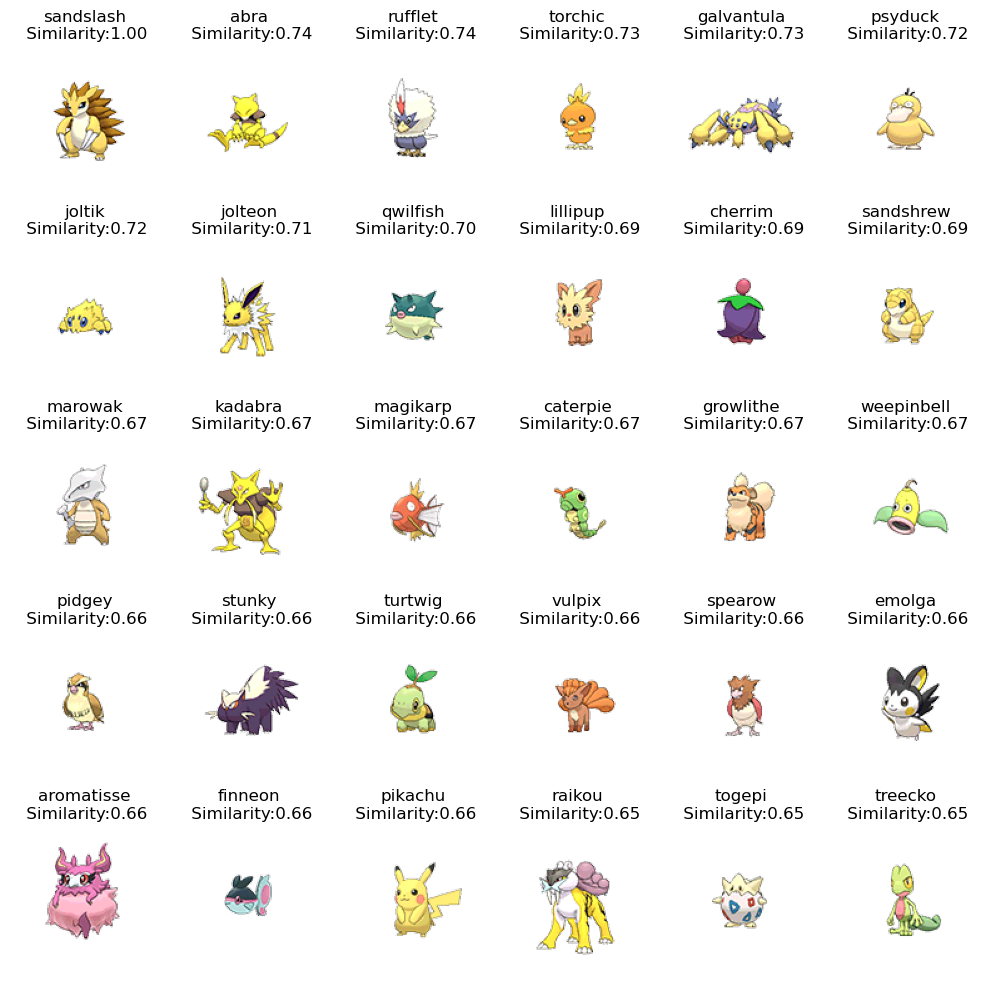

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def find_similar_images(query_img_path, features, img_paths):
    # 쿼리 이미지 로드
    img = Image.open(query_img_path)
    # 이미지 특징 추출
    query = fe.extract(img)

    # 코사인 유사도 계산
    similarities = cosine_similarity([query], features)

    # 유사도 순으로 정렬 (내림차순)
    sorted_indices = np.argsort(similarities[0])[::-1]

    # 상위 30개의 가장 유사한 이미지 가져오기
    top_indices = sorted_indices[:30]

    # 결과 시각화
    axes = []
    fig = plt.figure(figsize=(10, 10))
    for a, index in enumerate(top_indices):
        score = similarities[0][index]
        img_path = img_paths[index]
        img_name = os.path.basename(img_path)
        axes.append(fig.add_subplot(5, 6, a + 1))
        subplot_title = f"{img_name[:-4]}\n Similarity:{score:.2f}"
        axes[-1].set_title(subplot_title)
        plt.axis('off')
        plt.imshow(Image.open(img_path))
    fig.tight_layout()
    plt.show()

def main():

    query_img_path = "./images/images/sandslash.png"
    find_similar_images(query_img_path, features, img_paths)


if __name__ == '__main__':
    main()
    